In [13]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
working_dir_path = '/content/sample_data/CoronaTweetsSentimentAnalysis.csv'
df = pd.read_csv(working_dir_path,encoding = 'latin')

In [16]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",Positive
1,2,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg ...,Negative
2,3,44959,NaN,03-03-2020,Voting in the age of #coronavirus = hand sanitizer ? #SuperTuesday https://t.co/z0BeL4O6Dk,Positive
3,4,44963,"Boksburg, South Africa",04-03-2020,Best quality couches at unbelievably low prices available to order.\r\r\n\r\r\nWe are in Boksburg GP \r\r\n\r\r\nFor more info WhatsApp:\r\r\n084 764 8086\r\r\n\r\r\n#SuperTuesdsy #PowerTalk \r\r\...,Positive
4,5,44967,"Washington, DC",04-03-2020,"While we were busy watching election returns and bracing for a Covid-19 outbreak, Trump nominated a chemical-industry lobbyist to head the Consumer Product Safety Commission https://t.co/M2ShHI1Tn0",Positive


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       1988 non-null   int64 
 1   ScreenName     1988 non-null   int64 
 2   Location       1536 non-null   object
 3   TweetAt        1988 non-null   object
 4   OriginalTweet  1988 non-null   object
 5   Sentiment      1988 non-null   object
dtypes: int64(2), object(4)
memory usage: 93.3+ KB


In [18]:
df.shape

(1988, 6)

In [19]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [20]:
df.TweetAt.value_counts()

13-03-2020    654
12-03-2020    372
14-03-2020    336
15-03-2020    249
16-03-2020    232
11-03-2020     90
10-03-2020     34
07-03-2020      6
09-03-2020      6
02-03-2020      2
04-03-2020      2
05-03-2020      2
08-03-2020      2
03-03-2020      1
Name: TweetAt, dtype: int64

In [21]:
df['Location'].value_counts()

United States             42
London, England           25
Washington, DC            22
New York, NY              20
Los Angeles, CA           16
                          ..
Paris, France              1
FB.me/EnglishInRomania     1
West Palm Beach, FL        1
310                        1
Farmington, NM             1
Name: Location, Length: 1019, dtype: int64

In [22]:
df['Sentiment'].value_counts()

Negative    1041
Positive     947
Name: Sentiment, dtype: int64

In [23]:
df[df['Sentiment']=='Extremely Negative']

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment


In [24]:
df[df['Sentiment']=='Negative']

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1,2,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg ...,Negative
6,7,44973,Malta,05-03-2020,"#CoronaVirus #COVID_19 People are starting to become frightened and to do #PanicShopping. Many shelves, meanwhile, turn empty as #goods are sold. #FaceMasks &amp; disinfection liquid are sold out,...",Negative
8,9,44979,"Bondi Beach, Sydney",07-03-2020,When your usual grocery shopping @woolworths turns into a toilet paper fight in the supermarket aisle. Yikes. #toiletpaperpanic for the #coronavirus has taken a whole new level. https://t.co/aKJ28...,Negative
9,10,44980,NaN,07-03-2020,Coronavirus panic spreads: Costco is pulling free samples over COVID-19 - USA TODAY\r\r\n\r\r\nCoronavirus panic spreads: Costco is pulling free samples over COVID-19Â Â USA TODAY\r\r\n\r\r\n'It's...,Negative
10,11,44981,NaN,07-03-2020,"While you are stocking up, waiting for quarantine, if you can don't forget to donate food, water, and toiletries to your local food banks to help others without the means to stock up. Get ahead o...",Negative
...,...,...,...,...,...,...
1977,1978,48723,"West Virginia, USA",16-03-2020,"PSA: Stop panicking about COVID-19, you don't need to shelter yourselves from the outside world and stock up on toilet paper and food enough to stuff Old Faithful 10x over. If you want to go out a...",Negative
1978,1979,48724,"Houston, TX",16-03-2020,When I'm stopped by George at the grocery store - Should I cough on you George.. #coronapocolypse #coronavirus #StayTheFHome #COVID?19 #COVID2019 #COVID19 #CoronaVirusUpdates #CoronavirusOutbreak ...,Negative
1982,1983,48736,Texas,16-03-2020,Amazon delivery infrastructure strained as COVID-19 outbreak sparks surge in online shopping Â GeekWire\r\r\nhttps://t.co/UCcEiOY6qK,Negative
1985,1986,48745,Washington D.C.,16-03-2020,"@RicePolitics @MDCounties Craig, will you call on the General Assembly to enact a legal stay against debt collection activities now that thousands of Marylanders are without a paycheck? \r\r\n\r\r...",Negative


In [25]:
df[df['Sentiment']=='Neutral']

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment


In [26]:
df[df['Sentiment']=='Positive']

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",Positive
2,3,44959,NaN,03-03-2020,Voting in the age of #coronavirus = hand sanitizer ? #SuperTuesday https://t.co/z0BeL4O6Dk,Positive
3,4,44963,"Boksburg, South Africa",04-03-2020,Best quality couches at unbelievably low prices available to order.\r\r\n\r\r\nWe are in Boksburg GP \r\r\n\r\r\nFor more info WhatsApp:\r\r\n084 764 8086\r\r\n\r\r\n#SuperTuesdsy #PowerTalk \r\r\...,Positive
4,5,44967,"Washington, DC",04-03-2020,"While we were busy watching election returns and bracing for a Covid-19 outbreak, Trump nominated a chemical-industry lobbyist to head the Consumer Product Safety Commission https://t.co/M2ShHI1Tn0",Positive
5,6,44971,NaN,05-03-2020,"That's about a week from now. A bit optimistic. Probably it will take another month. Supply chain may be recovering, demand chain will be non-existent in US and Europe for the next month or two....",Positive
...,...,...,...,...,...,...
1980,1981,48732,NaN,16-03-2020,"Stuck inside? How about getting some reading in to fill the time, and your mind? For the #coronavirus #COVID?19 time, I've lowered all ebook prices to $0.99. Comedy, drama, action, philosophy, ...",Positive
1981,1982,48733,"Kansas, USA",16-03-2020,@GovLauraKelly PLEASE CLOSE ALL RETAIL that is not a pharmacy or a grocery store. People in Wyandotte County are not heading the warnings to STAY HOME. People like me (asthmatic) can't risk going ...,Positive
1983,1984,48737,Paraparaumu Beach,16-03-2020,Just been through K?piti New World which is busy. Staff say it's been that way since the COVID-19 case in Wellington hit the news. Still food on the shelves - a few gaps like long life milk appear...,Positive
1984,1985,48743,"Cincinnati, Ohio",16-03-2020,"Even though the Law Library is closed, ALL subscribers can access ebooks, EBSCO Legal forms, the National Consumer Law Center and research assistance remotely. Click here to find out more:\r\r\n\r...",Positive


In [27]:
df[df['Sentiment']=='Extremely Positive']

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment


In [28]:
pd.isnull(df["Sentiment"])


0       False
1       False
2       False
3       False
4       False
        ...  
1983    False
1984    False
1985    False
1986    False
1987    False
Name: Sentiment, Length: 1988, dtype: bool

In [29]:
missing_values = pd.DataFrame()
missing_values['column'] = df.columns

missing_values['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]
missing_values = missing_values.sort_values('percent')
missing_values = missing_values[missing_values['percent']>0]

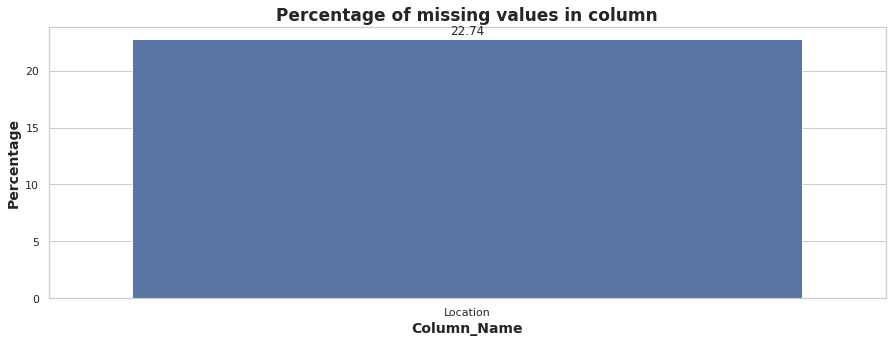

In [30]:
plt.figure(figsize=(15, 5))
sns.set(style='whitegrid', color_codes=True)
splot=sns.barplot(x='column', y='percent', data=missing_values)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.xlabel("Column_Name", size=14, weight="bold")
plt.ylabel("Percentage", size=14, weight="bold")
plt.title("Percentage of missing values in column",fontweight="bold",size=17)
plt.show()


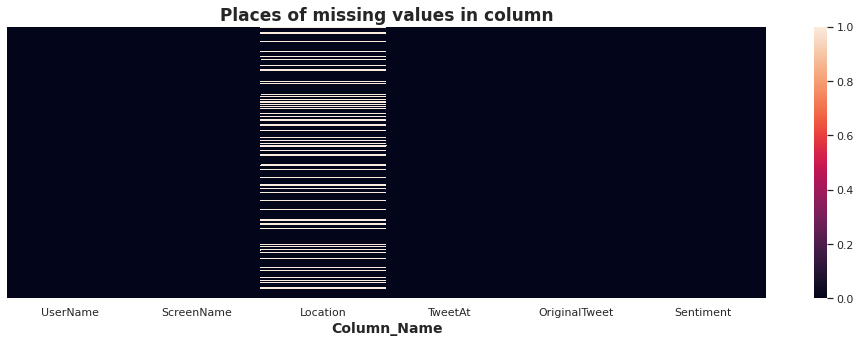

In [31]:
plt.figure(figsize=(17, 5))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False)
plt.xlabel("Column_Name", size=14, weight="bold")
plt.title("Places of missing values in column",fontweight="bold",size=17)
plt.show()

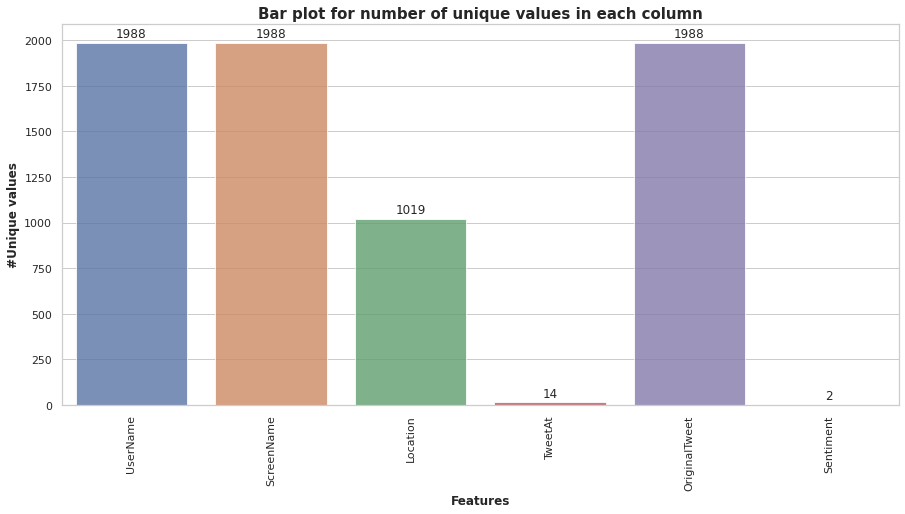

In [32]:
unique_df = pd.DataFrame()
unique_df['Features'] = df.columns
unique=[]
for i in df.columns:
    unique.append(df[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

In [33]:
loc_analysis = pd.DataFrame(df['Location'].value_counts().sort_values(ascending=False))
loc_analysis = loc_analysis.rename(columns={'Location':'count'})

In [34]:
import plotly.graph_objects as go


In [35]:
data = {
   "values": loc_analysis['count'][:15],
   "labels": loc_analysis.index[:15],
   "domain": {"column": 0},
   "name": "Location Name",
   "hoverinfo":"label+percent+name",
   "hole": .4,
   "type": "pie"
}
layout = go.Layout(title="<b>Ratio on Location</b>", legend=dict(x=0.1, y=1.1, orientation="h"))

data = [data]
fig = go.Figure(data = data, layout = layout)
fig.update_layout(title_x=0.5)
fig.show()

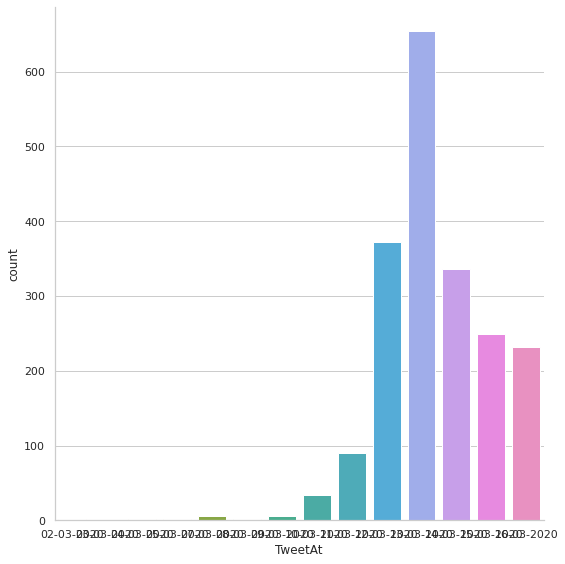

In [36]:
sns.catplot("TweetAt", data=df, kind="count", height=8)

In [37]:
Top_Location_Of_tweet= df['Location'].value_counts().head(10)

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('white')

In [38]:
Top_Location_Of_tweet.head(10)

United States       42
London, England     25
Washington, DC      22
New York, NY        20
Los Angeles, CA     16
Canada              15
London              14
Atlanta, GA         12
California, USA     12
Toronto, Ontario    11
Name: Location, dtype: int64

In [39]:
Top_Location_Of_tweet_df=pd.DataFrame(Top_Location_Of_tweet)
Top_Location_Of_tweet_df.reset_index(inplace=True)
Top_Location_Of_tweet_df.rename(columns={'index':'Location', 'Location':'Location_Count'}, inplace=True)
Top_Location_Of_tweet_df

,Location,Location_Count
0,United States,42
1,"London, England",25
2,"Washington, DC",22
3,"New York, NY",20
4,"Los Angeles, CA",16
5,Canada,15
6,London,14
7,"Atlanta, GA",12
8,"California, USA",12
9,"Toronto, Ontario",11


[Text(0, 0, 'United States'),
 Text(0, 0, 'London, England'),
 Text(0, 0, 'Washington, DC'),
 Text(0, 0, 'New York, NY'),
 Text(0, 0, 'Los Angeles, CA'),
 Text(0, 0, 'Canada'),
 Text(0, 0, 'London'),
 Text(0, 0, 'Atlanta, GA'),
 Text(0, 0, 'California, USA'),
 Text(0, 0, 'Toronto, Ontario')]

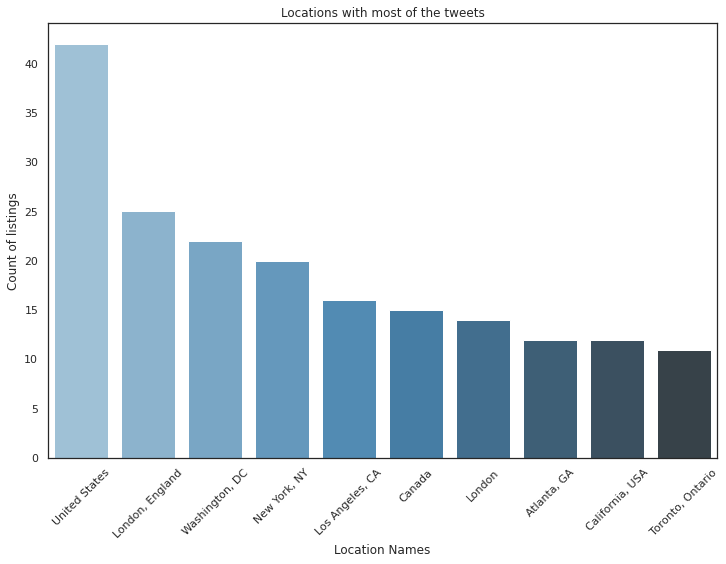

In [40]:
viz_1=sns.barplot(x="Location", y="Location_Count", data=Top_Location_Of_tweet_df,
                 palette='Blues_d')
viz_1.set_title('Locations with most of the tweets')
viz_1.set_ylabel('Count of listings')
viz_1.set_xlabel('Location Names')
viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=45)

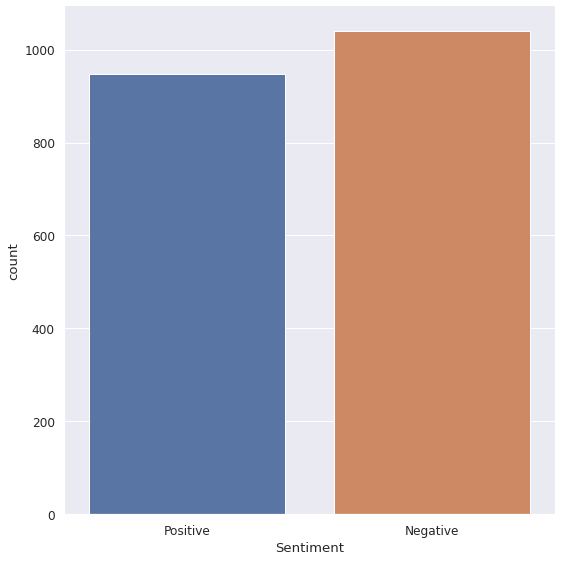

In [41]:
sns.set(font_scale=1.1)
sns.catplot("Sentiment", data=df, kind="count", height=8)

In [42]:
df.TweetAt.value_counts()

13-03-2020    654
12-03-2020    372
14-03-2020    336
15-03-2020    249
16-03-2020    232
11-03-2020     90
10-03-2020     34
07-03-2020      6
09-03-2020      6
02-03-2020      2
04-03-2020      2
05-03-2020      2
08-03-2020      2
03-03-2020      1
Name: TweetAt, dtype: int64

In [43]:
# write function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [44]:
# create new column with removed @user
df['Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')

In [45]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,1,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",Positive,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY"
1,2,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg ...,Negative,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg ...


In [46]:
import re
df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [47]:
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,1,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",Positive,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices."
1,2,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg ...,Negative,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg ...
2,3,44959,NaN,03-03-2020,Voting in the age of #coronavirus = hand sanitizer ? #SuperTuesday https://t.co/z0BeL4O6Dk,Positive,Voting in the age of #coronavirus = hand sanitizer ? #SuperTuesday


In [49]:
# remove special characters, numbers, punctuations
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z#]+',' ')

In [48]:
df.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,1,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",Positive,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices."
1,2,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg ...,Negative,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg ...
2,3,44959,NaN,03-03-2020,Voting in the age of #coronavirus = hand sanitizer ? #SuperTuesday https://t.co/z0BeL4O6Dk,Positive,Voting in the age of #coronavirus = hand sanitizer ? #SuperTuesday
3,4,44963,"Boksburg, South Africa",04-03-2020,Best quality couches at unbelievably low prices available to order.\r\r\n\r\r\nWe are in Boksburg GP \r\r\n\r\r\nFor more info WhatsApp:\r\r\n084 764 8086\r\r\n\r\r\n#SuperTuesdsy #PowerTalk \r\r\...,Positive,Best quality couches at unbelievably low prices available to order.\r\r\n\r\r\nWe are in Boksburg GP \r\r\n\r\r\nFor more info WhatsApp:\r\r\n084 764 8086\r\r\n\r\r\n#SuperTuesdsy #PowerTalk \r\r\...
4,5,44967,"Washington, DC",04-03-2020,"While we were busy watching election returns and bracing for a Covid-19 outbreak, Trump nominated a chemical-industry lobbyist to head the Consumer Product Safety Commission https://t.co/M2ShHI1Tn0",Positive,"While we were busy watching election returns and bracing for a Covid-19 outbreak, Trump nominated a chemical-industry lobbyist to head the Consumer Product Safety Commission"


In [50]:
# remove short words
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [51]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,1,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",Positive,When couldn find hand sanitizer Fred Meyer turned #Amazon But for pack Purell Check out how #coronavirus concerns are driving prices
1,2,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg ...,Negative,#Panic buying hits #NewYork City anxious shoppers stock food amp medical supplies after #healthcare worker her becomes #BigApple confirmed #coronavirus patient #Bloomberg staged event


In [52]:
# create new variable tokenized tweet 
tokenized_tweet = df['Tweet'].apply(lambda x: x.split())
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,1,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",Positive,When couldn find hand sanitizer Fred Meyer turned #Amazon But for pack Purell Check out how #coronavirus concerns are driving prices
1,2,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg ...,Negative,#Panic buying hits #NewYork City anxious shoppers stock food amp medical supplies after #healthcare worker her becomes #BigApple confirmed #coronavirus patient #Bloomberg staged event


In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [53]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,1,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",Positive,When couldn find hand sanitizer Fred Meyer turned #Amazon But for pack Purell Check out how #coronavirus concerns are driving prices
1,2,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg ...,Negative,#Panic buying hits #NewYork City anxious shoppers stock food amp medical supplies after #healthcare worker her becomes #BigApple confirmed #coronavirus patient #Bloomberg staged event


In [54]:
# join tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
# change df['Tweet'] to tokenized_tweet

In [55]:
df['Tweet']  = tokenized_tweet


In [56]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,1,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",Positive,When couldn find hand sanitizer Fred Meyer turned #Amazon But for pack Purell Check out how #coronavirus concerns are driving prices
1,2,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg ...,Negative,#Panic buying hits #NewYork City anxious shoppers stock food amp medical supplies after #healthcare worker her becomes #BigApple confirmed #coronavirus patient #Bloomberg staged event


In [57]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,1,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",Positive,When couldn find hand sanitizer Fred Meyer turned #Amazon But for pack Purell Check out how #coronavirus concerns are driving prices
1,2,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1st confirmed #coronavirus patient OR a #Bloomberg ...,Negative,#Panic buying hits #NewYork City anxious shoppers stock food amp medical supplies after #healthcare worker her becomes #BigApple confirmed #coronavirus patient #Bloomberg staged event


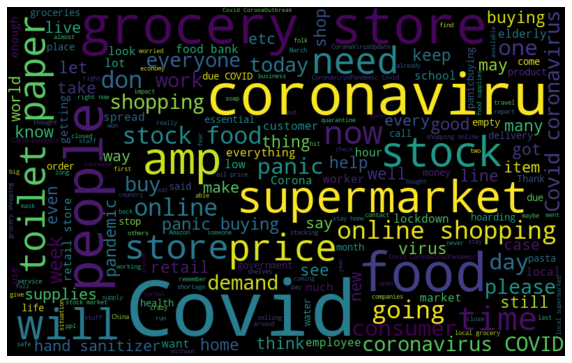

In [58]:
# create text from all tweets
all_words = ' '.join([text for text in df['Tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

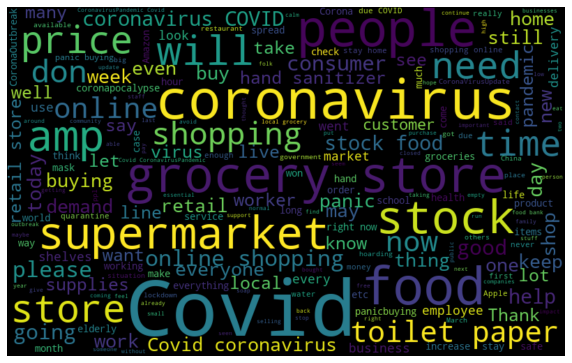

In [59]:
# create text from just normal tweets
normal_words = ' '.join([text for text in df['Tweet'][df['Sentiment'] == 'Positive']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

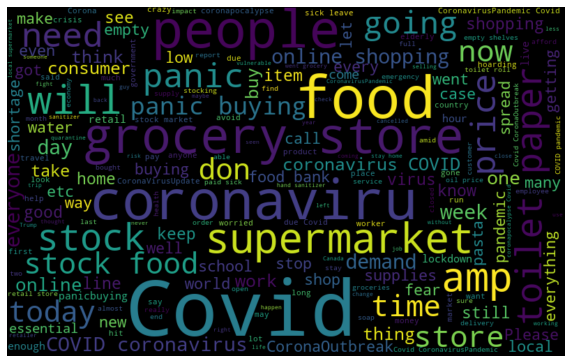

In [60]:
# create text from just normal tweets
normal_words = ' '.join([text for text in df['Tweet'][df['Sentiment'] == 'Negative']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

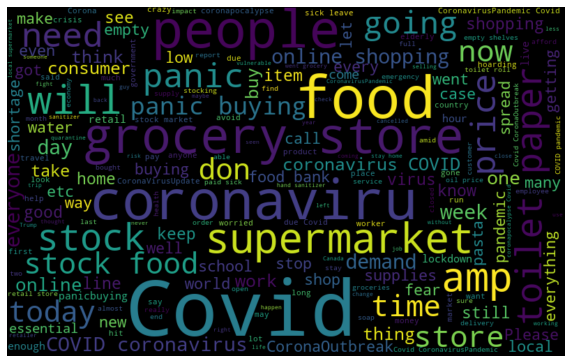

In [61]:
# create text from just normal tweets
normal_words = ' '.join([text for text in df['Tweet'][df['Sentiment'] == 'Negative']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [62]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

In [63]:
# extracting hashtags from non racist/sexist tweets
HT_Extremely_Positive = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Extremely Positive'])
HT_Positive = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Positive'])
HT_Neutral = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Neutral'])
HT_Negative = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Negative'])
HT_Extremely_Negative = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Extremely Negative'])



# unnesting list
HT_Extremely_Positive = sum(HT_Extremely_Positive, [])
HT_Positive = sum(HT_Positive, [])
HT_Neutral = sum(HT_Neutral, [])
HT_Negative = sum(HT_Negative,[])
HT_Extremely_Negative = sum(HT_Extremely_Negative,[])

In [64]:
print(HT_Extremely_Positive)

[]


In [65]:
print(HT_Positive)

['Amazon', 'coronavirus', 'coronavirus', 'SuperTuesday', 'SuperTuesdsy', 'PowerTalk', 'Covid_19', 'SayEntrepreneur', 'DJSBU', 'B1', 'FBA', 'CoronavirusUSA', 'COVID', 'Coronavirus', 'UI', 'Unemployment', 'PaidLeaveForAll', 'seniors', 'disabled', 'vets', 'Covid_19', 'coronavirus', 'Coronavirus', 'COVID2019', 'COVID2019', 'panicbuying', 'coronavirus', 'Coronavirus', 'COVID19', 'retail', 'ecommerce', 'study', 'coronavirus', 'COVID2019', 'Coronavirus', 'COVID2019', 'Manchester', 'iwilleatwithyou', 'Retail', 'store', 'coronavirus', 'coronavirus', 'COVID19', 'coronavirus', 'complexhealth', 'Americans', 'coronavirus', 'COVID19Canada', 'CoronavirusCanada', 'bcseniors', 'coronavirus', 'bigW', 'eastgardens', 'Coronavirus', 'stimulus', 'auspol', 'coronavirus', 'sxsw', 'coronavirus', 'Coronavirus', 'CancelEverything', 'tending', 'COVID19', 'coronavirus', 'coronavirus', 'coronavirus', 'foodsecurity', '4', 'Apple', 'Coronavirus', 'LouisVuitton', 'coronavirus', 'quarantine', 'pandemic', 'Forex', 'fore

In [66]:
print(HT_Neutral)

[]


In [67]:
print(HT_Negative)

['Panic', 'NewYork', 'healthcare', 'BigApple', 'coronavirus', 'Bloomberg', 'QAnon', 'QAnon2018', 'QAnon2020', 'Election2020', 'CDC', 'CoronaVirus', 'COVID_19', 'PanicShopping', 'goods', 'FaceMasks', 'Blockchain', 'CryptoNews', 'toiletpaperpanic', 'coronavirus', 'covid19', 'coronavirus', 'coronavirus', 'COVID19', 'coronavirus', 'vaccinations', 'Coronavirus', 'ToiletPaper', 'CoronaVirus', 'coronavirus', 'coronavirus', 'Coronavirus', 'doomsdayBunker', 'coronavirus', 'COVID19', 'Trumpdemic', 'coronavirus', 'DonaldTrump', 'COVID19', 'Trumpdemic', 'coronaviru', 'earnings', 'coronavirus', 'TrustedData', 'Refinitiv', 'COVID19', 'COVID2019', 'remoteworking', 'broadband', 'rural', 'coronavirus', 'payrolltax', 'coronavirus', 'Covid_19', 'Coronavirus', 'ShippingContainers', 'MrBox', 'hamsterkÃ', 'COVID2019', 'covid19ireland', 'Coronavirusireland', 'panicbuyingireland', 'panicbuying', 'coronavirus', 'Coronavirus', 'trusselltrust', 'coronavirus', 'foodbanks', 'poverty', 'uk', 'COVID2019', 'coronavir

In [68]:
print(HT_Extremely_Negative)

[]


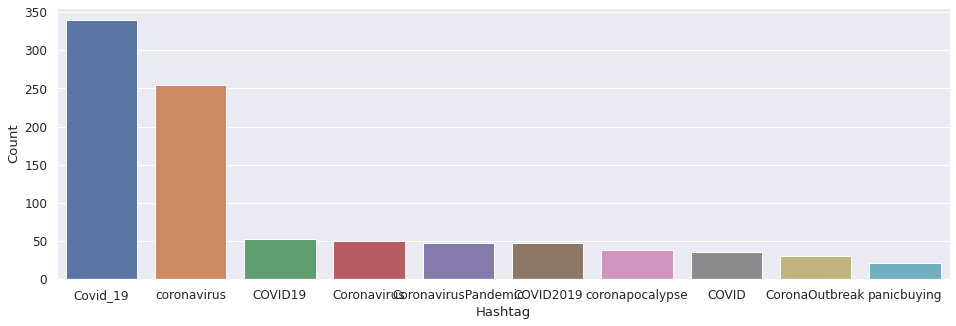

In [69]:
# making frequency distribution top 10 Positive hashtags
a = nltk.FreqDist(HT_Positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,5))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

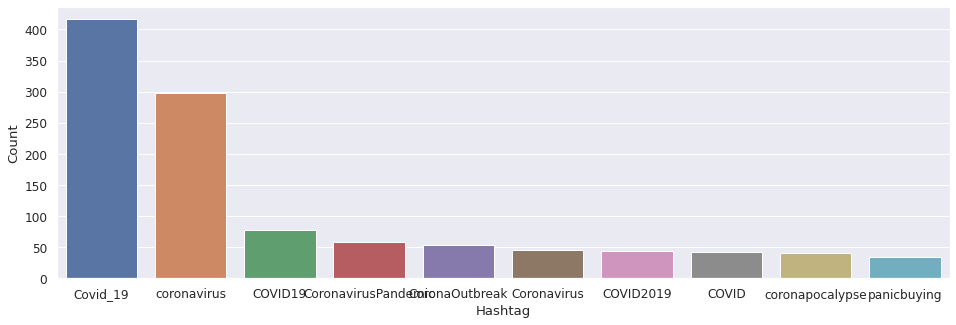

In [70]:
# making frequency distribution top 10 Positive hashtags
a = nltk.FreqDist(HT_Negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,5))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

In [71]:
new_df = df[['Tweet','Sentiment']]

In [72]:
new_df.head()

,Tweet,Sentiment
0,When couldn find hand sanitizer Fred Meyer turned #Amazon But for pack Purell Check out how #coronavirus concerns are driving prices,Positive
1,#Panic buying hits #NewYork City anxious shoppers stock food amp medical supplies after #healthcare worker her becomes #BigApple confirmed #coronavirus patient #Bloomberg staged event,Negative
2,Voting the age #coronavirus hand sanitizer #SuperTuesday,Positive
3,Best quality couches unbelievably low prices available order are Boksburg For more info WhatsApp #SuperTuesdsy #PowerTalk #Covid #SayEntrepreneur #DJSBU,Positive
4,While were busy watching election returns and bracing for Covid outbreak Trump nominated chemical industry lobbyist head the Consumer Product Safety Commission,Positive


In [73]:
df['Sentiment'].value_counts()

Negative    1041
Positive     947
Name: Sentiment, dtype: int64

In [74]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [75]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [76]:
new_df['Tweet'].apply(lambda x: [item for item in x if item not in stop])

0       [W, h, e, n,  , c, u, l, n,  , f, n,  , h, n,  , n, z, e, r,  , F, r, e,  , M, e, e, r,  , u, r, n, e,  , #, A, z, n,  , B, u,  , f, r,  , p, c, k,  , P, u, r, e, l, l,  , C, h, e, c, k,  , u,  , ...
1       [#, P, n, c,  , b, u, n, g,  , h,  , #, N, e, w, Y, r, k,  , C,  , n, x, u,  , h, p, p, e, r,  , c, k,  , f,  , p,  , e, c, l,  , u, p, p, l, e,  , f, e, r,  , #, h, e, l, h, c, r, e,  , w, r, k, ...
2                                                                                                     [V, n, g,  , h, e,  , g, e,  , #, c, r, n, v, r, u,  , h, n,  , n, z, e, r,  , #, S, u, p, e, r, T, u, e]
3       [B, e,  , q, u, l,  , c, u, c, h, e,  , u, n, b, e, l, e, v, b, l,  , l, w,  , p, r, c, e,  , v, l, b, l, e,  , r, e, r,  , r, e,  , B, k, b, u, r, g,  , F, r,  , r, e,  , n, f,  , W, h, A, p, p, ...
4       [W, h, l, e,  , w, e, r, e,  , b, u,  , w, c, h, n, g,  , e, l, e, c, n,  , r, e, u, r, n,  , n,  , b, r, c, n, g,  , f, r,  , C, v,  , u, b, r, e, k,  , T, r, 

In [77]:
new_df.head(6)

,Tweet,Sentiment
0,When couldn find hand sanitizer Fred Meyer turned #Amazon But for pack Purell Check out how #coronavirus concerns are driving prices,Positive
1,#Panic buying hits #NewYork City anxious shoppers stock food amp medical supplies after #healthcare worker her becomes #BigApple confirmed #coronavirus patient #Bloomberg staged event,Negative
2,Voting the age #coronavirus hand sanitizer #SuperTuesday,Positive
3,Best quality couches unbelievably low prices available order are Boksburg For more info WhatsApp #SuperTuesdsy #PowerTalk #Covid #SayEntrepreneur #DJSBU,Positive
4,While were busy watching election returns and bracing for Covid outbreak Trump nominated chemical industry lobbyist head the Consumer Product Safety Commission,Positive
5,That about week from now bit optimistic Probably will take another month Supply chain may recovering demand chain will non existent and Europe for the next month two spx qqq,Positive


In [78]:
new_df.shape

(1988, 2)

In [79]:
new_df.isnull().sum()

Tweet        0
Sentiment    0
dtype: int64

In [80]:
new_df.head(7)

,Tweet,Sentiment
0,When couldn find hand sanitizer Fred Meyer turned #Amazon But for pack Purell Check out how #coronavirus concerns are driving prices,Positive
1,#Panic buying hits #NewYork City anxious shoppers stock food amp medical supplies after #healthcare worker her becomes #BigApple confirmed #coronavirus patient #Bloomberg staged event,Negative
2,Voting the age #coronavirus hand sanitizer #SuperTuesday,Positive
3,Best quality couches unbelievably low prices available order are Boksburg For more info WhatsApp #SuperTuesdsy #PowerTalk #Covid #SayEntrepreneur #DJSBU,Positive
4,While were busy watching election returns and bracing for Covid outbreak Trump nominated chemical industry lobbyist head the Consumer Product Safety Commission,Positive
5,That about week from now bit optimistic Probably will take another month Supply chain may recovering demand chain will non existent and Europe for the next month two spx qqq,Positive
6,#CoronaVirus #COVID People are starting become frightened and #PanicShopping Many shelves meanwhile turn empty #goods are sold #FaceMasks amp disinfection liquid are sold out they are sold for exo...,Negative


In [81]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(new_df,test_size = 0.2,random_state=0,stratify = new_df.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (1590, 2)
valid shape :  (398, 2)


In [82]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.Tweet.values)
X_valid = vectorizer.transform(valid.Tweet.values)

y_train = train.Sentiment.values
y_valid = valid.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (1590, 6160)
X_train.shape :  (398, 6160)
y_train.shape :  (1590,)
y_valid.shape :  (398,)


In [83]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_valid)
NB_accuracy = accuracy_score(y_valid,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Validation accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_valid))

training accuracy Score    :  0.9672955974842767
Validation accuracy Score :  0.5703517587939698
              precision    recall  f1-score   support

    Negative       0.62      0.58      0.60       221
    Positive       0.52      0.55      0.53       177

    accuracy                           0.57       398
   macro avg       0.57      0.57      0.57       398
weighted avg       0.57      0.57      0.57       398



In [84]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_valid)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_valid))

Training accuracy Score    :  0.9981132075471698
Validation accuracy Score :  0.6432160804020101
              precision    recall  f1-score   support

    Negative       0.57      0.69      0.63       172
    Positive       0.72      0.61      0.66       226

    accuracy                           0.64       398
   macro avg       0.65      0.65      0.64       398
weighted avg       0.66      0.64      0.64       398



In [85]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_valid)
rf_accuracy = accuracy_score(y_valid,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Validation accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_valid))

Training accuracy Score    :  1.0
Validation accuracy Score :  0.6055276381909548
              precision    recall  f1-score   support

    Negative       0.72      0.60      0.65       247
    Positive       0.48      0.61      0.54       151

    accuracy                           0.61       398
   macro avg       0.60      0.61      0.60       398
weighted avg       0.63      0.61      0.61       398



In [86]:
#takes huge amount of time to execute
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_valid)
xgb_accuracy = accuracy_score(y_valid,xgb_prediction)
print("Training accuracy Score    : ",xgboost_clf.score(X_train,y_train))
print("Validation accuracy Score : ",xgb_accuracy )
print(classification_report(xgb_prediction,y_valid))

Training accuracy Score    :  0.7377358490566037
Validation accuracy Score :  0.6180904522613065
              precision    recall  f1-score   support

    Negative       0.79      0.60      0.68       274
    Positive       0.43      0.65      0.52       124

    accuracy                           0.62       398
   macro avg       0.61      0.63      0.60       398
weighted avg       0.68      0.62      0.63       398



In [87]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_valid)
svc_accuracy = accuracy_score(y_valid,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Validation accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_valid))

Training accuracy Score    :  0.9754716981132076
Validation accuracy Score :  0.6231155778894473
              precision    recall  f1-score   support

    Negative       0.72      0.62      0.67       242
    Positive       0.52      0.63      0.57       156

    accuracy                           0.62       398
   macro avg       0.62      0.62      0.62       398
weighted avg       0.64      0.62      0.63       398



In [88]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))

Training accuracy Score    :  0.9930817610062893
Validation accuracy Score :  0.6381909547738693
              precision    recall  f1-score   support

    Negative       0.67      0.65      0.66       214
    Positive       0.61      0.62      0.61       184

    accuracy                           0.64       398
   macro avg       0.64      0.64      0.64       398
weighted avg       0.64      0.64      0.64       398



In [89]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_valid)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_valid))

Training accuracy Score    :  0.9981132075471698
Validation accuracy Score :  0.6432160804020101
              precision    recall  f1-score   support

    Negative       0.57      0.69      0.63       172
    Positive       0.72      0.61      0.66       226

    accuracy                           0.64       398
   macro avg       0.65      0.65      0.64       398
weighted avg       0.66      0.64      0.64       398



In [1]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [2]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

In [90]:
clf2 = CatBoostClassifier()


clf2.fit(X_train, y_train,  
        eval_set=(X_valid, y_valid), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf2.is_fitted()))
print('CatBoost model parameters:')
print(clf2.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{}


In [91]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_valid)
NB_accuracy = accuracy_score(y_valid,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Validation accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_valid))

training accuracy Score    :  0.9672955974842767
Validation accuracy Score :  0.5703517587939698
              precision    recall  f1-score   support

    Negative       0.62      0.58      0.60       221
    Positive       0.52      0.55      0.53       177

    accuracy                           0.57       398
   macro avg       0.57      0.57      0.57       398
weighted avg       0.57      0.57      0.57       398



In [92]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_valid)
rf_accuracy = accuracy_score(y_valid,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Validation accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_valid))

Training accuracy Score    :  1.0
Validation accuracy Score :  0.6331658291457286
              precision    recall  f1-score   support

    Negative       0.76      0.62      0.68       254
    Positive       0.49      0.65      0.56       144

    accuracy                           0.63       398
   macro avg       0.63      0.64      0.62       398
weighted avg       0.66      0.63      0.64       398



In [93]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))

Training accuracy Score    :  0.9930817610062893
Validation accuracy Score :  0.6381909547738693
              precision    recall  f1-score   support

    Negative       0.67      0.65      0.66       214
    Positive       0.61      0.62      0.61       184

    accuracy                           0.64       398
   macro avg       0.64      0.64      0.64       398
weighted avg       0.64      0.64      0.64       398



In [94]:
clf2 = CatBoostClassifier()


clf2.fit(X_train, y_train,  
        eval_set=(X_valid, y_valid), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf2.is_fitted()))
print('CatBoost model parameters:')
print(clf2.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{}


In [95]:
catboost_prediction = clf2.predict(X_valid)
catboost_accuracy = accuracy_score(y_valid,catboost_prediction)
print("Training accuracy Score    : ",clf2.score(X_train,y_train))
print("Validation accuracy Score : ",catboost_accuracy )
print(classification_report(catboost_prediction,y_valid))

Training accuracy Score    :  0.9490566037735849
Validation accuracy Score :  0.6557788944723618
              precision    recall  f1-score   support

    Negative       0.71      0.66      0.68       223
    Positive       0.60      0.65      0.62       175

    accuracy                           0.66       398
   macro avg       0.65      0.66      0.65       398
weighted avg       0.66      0.66      0.66       398



In [96]:
#takes huge amount of time to execute
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_valid)
xgb_accuracy = accuracy_score(y_valid,xgb_prediction)
print("Training accuracy Score    : ",xgboost_clf.score(X_train,y_train))
print("Validation accuracy Score : ",xgb_accuracy )
print(classification_report(xgb_prediction,y_valid))

Training accuracy Score    :  0.7377358490566037
Validation accuracy Score :  0.6180904522613065
              precision    recall  f1-score   support

    Negative       0.79      0.60      0.68       274
    Positive       0.43      0.65      0.52       124

    accuracy                           0.62       398
   macro avg       0.61      0.63      0.60       398
weighted avg       0.68      0.62      0.63       398



In [97]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_valid)
svc_accuracy = accuracy_score(y_valid,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Validation accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_valid))

Training accuracy Score    :  0.9754716981132076
Validation accuracy Score :  0.6231155778894473
              precision    recall  f1-score   support

    Negative       0.72      0.62      0.67       242
    Positive       0.52      0.63      0.57       156

    accuracy                           0.62       398
   macro avg       0.62      0.62      0.62       398
weighted avg       0.64      0.62      0.63       398



In [98]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'XGBoost','CatBoost'],
    'Test accuracy': [svc_accuracy, logreg_accuracy, 
              rf_accuracy, NB_accuracy, 
              sgd_accuracy, xgb_accuracy,catboost_accuracy]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
6,CatBoost,0.655779
4,Stochastic Gradient Decent,0.643216
1,Logistic Regression,0.638191
2,Random Forest,0.633166
0,Support Vector Machines,0.623116
5,XGBoost,0.618090
3,Naive Bayes,0.570352
